# Deep Learning for Aqueous Solubility Prediction

<a rel="license" href="https://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

**Authors**: 
- Dr Antonia Mey (antonia.mey@ed.ac.uk)
- Rohan Gorantla (rohan.gorantla@ed.ac.uk)

**About aqueous solubility prediction task**:

Water is a ubiquitous solvent in both chemistry and life, so it's not surprising that the solubility of compounds in water is crucial in various fields, such as drug discovery, paint and coatings, the environment, and energy storage. However, measuring and predicting the aqueous solubility of compounds is a challenging and ongoing problem in chemistry. To tackle this, various data-driven prediction models have been created to supplement traditional physics-based methods. Despite the many efforts made over the years, there are still difficulties in developing a solubility prediction model that is accurate enough for many practical applications.

**Task:** Train a DL model to predict if the given molecule (SMILES) will be soluble in water or not.

---



**Learning Objectives**:

* To build and train deep neural networks for solubility prediction from SMILES data using Pytorch.
* Preparing the data for trainig and testing the DL model.
* Using RDKit to extract features from SMILES string.
* Tuning the neural network parameters to improve the learning of the model for the given solubilitity prediction task.


In [1]:
!pip install biopython
#!pip install rdkit-pypi
!pip install rdkit-pypi==2022.3.5
!pip install pysmiles
!pip install datamol
!pip install deepchem
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 10.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 KB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Gettin

To get started with this tutorial, let's importing some packages.

In [2]:
import os, math
import pandas as pd
import numpy as np
import deepchem as dc
from sklearn.metrics import confusion_matrix, roc_curve,auc

# RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import DataStructs,AllChem
from rdkit.Chem import rdmolfiles


# plotting
import seaborn as sns
import matplotlib.pyplot as plt

#Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision.transforms as transforms
from   torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

## 1. Introduction- Data Prepartion and Exploratory Data Anlaysis

In this tutorial we will use the solubility prediciton data from AqSolDB dataset to train the DL models.

**Data Source**: Sorkun, M.C., Khetan, A. & Er, S. AqSolDB, a curated reference set of aqueous solubility and 2D descriptors for a diverse set of compounds. Sci Data 6, 143 (2019). https://doi.org/10.1038/s41597-019-0151-1

Let's begin by loading the AqSolDB dataset from the csv file in the data folder.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset into a dataframe
file_path = '/content/drive/My Drive/SolubilityPrediction/solubility_dataset.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [4]:
df

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.000000,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.000000,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.000000,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.000000,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.000000,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,I-84,tetracaine,InChI=1S/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9...,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,0.000000,1,G1,264.369,...,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548e+00,374.236893
9978,I-85,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,0.000000,1,G1,444.440,...,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922e+00,1148.584975
9979,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,...,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720e+00,251.049732
9980,I-93,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,0.000000,1,G1,454.611,...,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333e+00,938.203977


<div class="alert alert-success">
<b>Task 1a.</b> From the data frame above, print the number of compounds and list of features in the dataset.</div>

In [5]:
print("Number of compounds in the dataset: ", df.shape[0])
print("Dataset columns: ", list(df.columns))


Number of compounds in the dataset:  9982
Dataset columns:  ['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD', 'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT']


<div class="alert alert-success">
<b>Task 1b.</b> What are the two features that are required in our task to predict solubility of the molecule from SMILES representation ?</div>

<details>
<summary> <mark> Solution: </mark> </summary>

Features:
- 'SMILES'
- 'Solubility'

</details>

The chosen 
unit of solubility in this dataset is LogS, where S is the aqueous solubility in mol/L (or M). Units such as g/L and mg/L were converted to LogS using the molecular mass of the compounds.

<div class="alert alert-success">
<b>Task 1c.</b> Plot a histogram to analyse the distribution of 'Solubility' measurement across the entire dataset. You can use seaborn histplot for this task. </div>

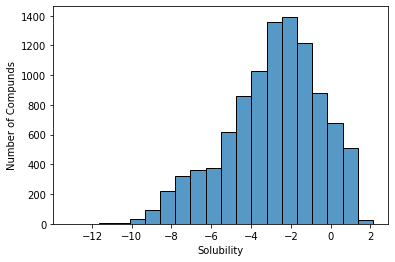

In [6]:
sns.histplot(df['Solubility'],bins=20)
plt.ylabel('Number of Compunds')
plt.show()

Now we want to categorise the Solubility data into two classes- 0 for insoluble and 1 for soluble compounds. These compounds can be classified according to solubility values (LogS).

Compounds with 0 and higher solubility value are highly soluble, those in the range of 0 to −2 are soluble, those in the range of −2 to −4 are slightly soluble and insoluble if less than −4.

<div class="alert alert-success">
<b>Task 1d.</b> Create a "isSoluble" feature in the dataframe. "isSoluble" is a binary variable where 1 denotes all soluble compounds (i.e., whose Solubility>-2) and 0 for insoluble compounds. Report the number of compounds in both these classes. </div>

In [7]:
df["isSoluble"] = (df.Solubility > -2).astype(int)
print(df.isSoluble.value_counts())

0    6086
1    3896
Name: isSoluble, dtype: int64


<div class="alert alert-success">
<b>Task 1e.</b> Plot a histogram to analyse the distribution of 'MolWt' of compunds less than 1000g/mol and its relationship with 'isSoluble' feature.  You can use seaborn histplot for this task and set bins=40. </div>

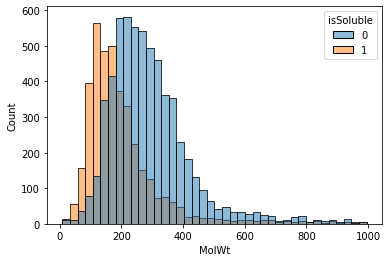

In [10]:
sns.histplot(x="MolWt", hue='isSoluble', data=df[df.MolWt < 1000], bins=40);

In [ ]:
### Below cells till section 2 start are not required

In [ ]:
df_upd = df[["ID", "SMILES", "Solubility", "MolWt", "isSoluble"]]
PandasTools.AddMoleculeColumnToFrame(df_upd, 'SMILES', 'Molecule', includeFingerprints=True)
df_upd

In [ ]:
# Plot a scatterplot of solubility values against other features
sns.pairplot(df, x_vars=['MolWt','MolLogP', 'NumHDonors', 'NumAromaticRings', 'NumRotatableBonds'], y_vars='Solubility')
plt.show()

In [ ]:
# Plot a scatterplot of solubility values against other features
sns.pairplot(df, x_vars=['MolWt','MolLogP', 'NumHDonors', 'NumAromaticRings', 'NumRotatableBonds'], y_vars='isSoluble')
plt.show()

## 2. Data Preprocessing- Feature extraction and splitting the datasets

Molecular Fingerprinting- ECFP

In [11]:
# Convert SMILES strings to ECFP fingerprints
def get_fingerprints(smiles):
    m = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
    arr = np.zeros((1,1024), dtype=np.float32)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

From the dataframe above, we will now select the input i.e., SMILES string and initialize it to the variable **X** and the binary solubility scores to the variable **y**. We will then get the Morgan fingerprints for the input **X**.

In [12]:
X = df["SMILES"]
y=np.array(df["isSoluble"])
#Get ECFP Fingerprints
X1 = X.apply(get_fingerprints).apply(lambda x: np.array(x, dtype=np.float32))
X1 = np.concatenate(X1.values)
X1 = X1.reshape(-1, 1024)

Now we have **X1** with fingerprints for all the molecules in the dataset and corresponding solubility scores. 

<div class="alert alert-success">
<b>Task 2a.</b> Split X and y into train, test and validation sets using Sklearn. Use 80% data for training and 20% data for testing; You can use 20% of the training data for validation set. </div>

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2)

# Split the train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


We will now have to convert the train, val and test sets into tensors and then use pytorch DataLoader to wrap these samples for training the DL models.

In [15]:
# Convert your data into tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)

# Wrap your data in TensorDataset
train_dataset = TensorDataset(X_train, y_train)

# Create the dataloaders
batch_size = 128
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


<ipython-input-15-85b0e4e2611b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-15-85b0e4e2611b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.int64)


<div class="alert alert-success">
<b>Task 2b.</b> Similar to the train set as shown in cell above, prepare the testloader and validation loader. </div>

In [16]:
# Convert your data into tensors
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Wrap your data in TensorDataset
val_dataset = TensorDataset(X_val, y_val)
test_dataset= TensorDataset(X_test, y_test)

# Create the dataloaders
batch_size = 128
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 3. Training the Deep Neural Network 

In [78]:
# Define the DNN model
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1) # Change the output layer to 2 classes
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #x = F.softmax(self.fc5(x), dim=1) # Use softmax activation to get probabilities
        x = F.sigmoid(self.fc5(x)) # Use softmax activation to get probabilities
        return x


In [21]:
# Initialize the model, loss function, and optimizer
model = DNN()
criterion = nn.CrossEntropyLoss() # Use cross entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Use Adam optimizer


In [22]:
summary(model)

Layer (type:depth-idx)                   Param #
DNN                                      --
├─Linear: 1-1                            524,800
├─Linear: 1-2                            131,328
├─Linear: 1-3                            32,896
├─Linear: 1-4                            8,256
├─Linear: 1-5                            130
Total params: 697,410
Trainable params: 697,410
Non-trainable params: 0

In [23]:
# Train the model and keep track of validation loss
train_loss = []
val_loss = []
num_epochs = 100

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long()) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(trainloader)
    train_loss.append(avg_train_loss)
    
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            val_batch_loss = criterion(outputs, labels.long()) 
            val_running_loss += val_batch_loss.item()
        
    avg_val_loss = val_running_loss / len(valloader)
    val_loss.append(avg_val_loss)


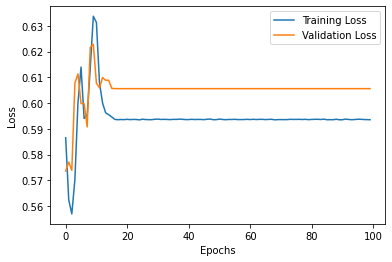

In [25]:
# Plot the training and validation loss
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
# Test the model on the test data
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, target = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) # Get the class with the highest probability
        total += target.size(0)
        correct += (predicted == target.long()).sum().item() # Convert target to long and compare
        predictions += predicted.tolist()
        true_labels += target.tolist()


In [44]:
accuracy = correct / total
print('Accuracy of the network on the test data: %d %%' % (100 * accuracy))



Accuracy of the network on the test data: 72 %


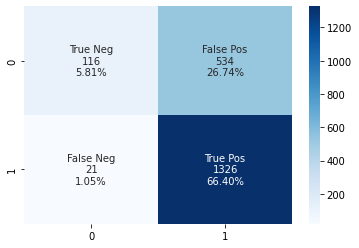

In [51]:
# Plot confusion matrix
cf_matrix= confusion_matrix(true_labels, predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')



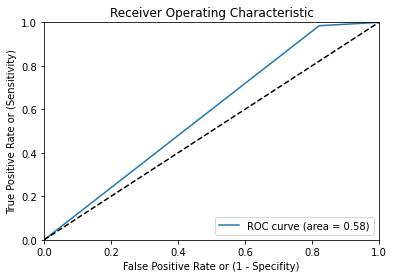

In [54]:

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_DNN_500Epochs.pt')

In [80]:
# Initialize the model, loss function, and optimizer
model = DNN()
criterion =nn.BCEWithLogitsLoss() # Use cross entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Use Adam optimizer


In [82]:
# Train the model and keep track of validation loss
train_loss = []
val_loss = []
num_epochs = 100

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(trainloader)
    train_loss.append(avg_train_loss)
    
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            val_batch_loss = criterion(outputs, labels.long()) 
            val_running_loss += val_batch_loss.item()
        
    avg_val_loss = val_running_loss / len(valloader)
    val_loss.append(avg_val_loss)
    print("Epoch {}: Training loss: {:.4f}, Validation loss: {:.4f}".format(epoch + 1, avg_train_loss, avg_val_loss))



ValueError: ignored

In [ ]:
# Plot the training and validation loss
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [75]:
# Test the model on the test data
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, target = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) # Get the class with the highest probability
        total += target.size(0)
        correct += (predicted == target.long()).sum().item() # Convert target to long and compare
        predictions += predicted.tolist()
        true_labels += target.tolist()

In [76]:
accuracy = correct / total
print('Accuracy of the network on the test data: %d %%' % (100 * accuracy))

Accuracy of the network on the test data: 32 %


### 3.1. Convolutional Neural Networks

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the 1D CNN model
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 256, 128)
        self.fc2 = nn.Linear(128, 2)
        self.softmax = nn.Softmax()
    
    def forward(self, x):
        x = x.reshape(-1, 1, 1024)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.reshape(-1, 32 * 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [91]:
# Initialize the model, loss function, and optimizer
model_cnn = CNN1D()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.01)

In [92]:
summary(model_cnn)

Layer (type:depth-idx)                   Param #
CNN1D                                    --
├─Conv1d: 1-1                            64
├─MaxPool1d: 1-2                         --
├─Conv1d: 1-3                            1,568
├─MaxPool1d: 1-4                         --
├─Linear: 1-5                            1,048,704
├─Linear: 1-6                            258
├─Softmax: 1-7                           --
Total params: 1,050,594
Trainable params: 1,050,594
Non-trainable params: 0

In [95]:
# Train the CNN model and keep track of validation loss
train_loss1 = []
val_loss1 = []
num_epochs = 50

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        #labels = labels.reshape(-1, 1)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(trainloader)
    train_loss1.append(avg_train_loss)
    
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            outputs = model_cnn(inputs)
            #labels = labels.reshape(-1, 1)
            val_batch_loss = criterion(outputs, labels.long())
            val_running_loss += val_batch_loss.item()
        
    avg_val_loss = val_running_loss / len(valloader)
    val_loss1.append(avg_val_loss)
    print("Epoch {}: Training loss: {:.4f}, Validation loss: {:.4f}".format(epoch + 1, avg_train_loss, avg_val_loss))
    


<ipython-input-90-0b977caa2d77>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Epoch 1: Training loss: 0.6469, Validation loss: 0.6301
Epoch 2: Training loss: 0.6446, Validation loss: 0.6301
Epoch 3: Training loss: 0.6446, Validation loss: 0.6301
Epoch 4: Training loss: 0.6445, Validation loss: 0.6301
Epoch 5: Training loss: 0.6445, Validation loss: 0.6301
Epoch 6: Training loss: 0.6445, Validation loss: 0.6301
Epoch 7: Training loss: 0.6445, Validation loss: 0.6301
Epoch 8: Training loss: 0.6445, Validation loss: 0.6301
Epoch 9: Training loss: 0.6445, Validation loss: 0.6301
Epoch 10: Training loss: 0.6445, Validation loss: 0.6301
Epoch 11: Training loss: 0.6445, Validation loss: 0.6301
Epoch 12: Training loss: 0.6443, Validation loss: 0.6301
Epoch 13: Training loss: 0.6444, Validation loss: 0.6301
Epoch 14: Training loss: 0.6446, Validation loss: 0.6301
Epoch 15: Training loss: 0.6445, Validation loss: 0.6301
Epoch 16: Training loss: 0.6444, Validation loss: 0.6301
Epoch 17: Training loss: 0.6447, Validation loss: 0.6301
Epoch 18: Training loss: 0.6446, Validat

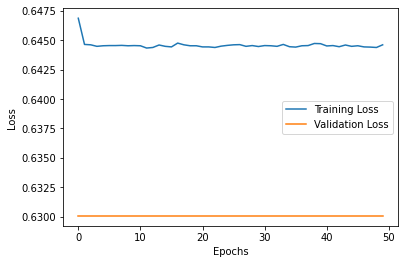

In [96]:
# Plot the validation loss
plt.plot(range(num_epochs), train_loss1, label='Training Loss')
plt.plot(range(num_epochs), val_loss1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [97]:
# Test the model on the test data
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, target = data
        outputs = model_cnn(inputs)
        _, predicted = torch.max(outputs.data, 1) # Get the class with the highest probability
        total += target.size(0)
        correct += (predicted == target.long()).sum().item() # Convert target to long and compare
        predictions += predicted.tolist()
        true_labels += target.tolist()


<ipython-input-90-0b977caa2d77>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [98]:
accuracy = correct / total
print('Accuracy of the network on the test data: %d %%' % (100 * accuracy))

Accuracy of the network on the test data: 67 %


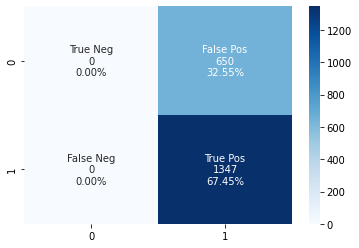

In [99]:
# Plot confusion matrix
cf_matrix= confusion_matrix(true_labels, predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

